In [1]:
import os
import json
import hoomd
import codecs

import numpy as np

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render

from polykit.generators.initial_conformations import grow_cubic

In [2]:
# Initialise HooMD on the CPU or GPU, based on availability
hoomd_device = build.get_hoomd_device()

HOOMD is running on the following GPU(s):
[0] NVIDIA A100-PCIE-40GB 108 SM_8.0 @ 1.41 GHz, 40339 MiB DRAM


In [3]:
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)

Using entropy-harvested random seed: 49709


In [4]:
# Initialize empty simulation object
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

In [5]:
# Simulate two chromosomes comprised of 5000 (resp. 10000) monomers each, with number density 0.2
density = 0.2
chromosome_sizes = [5000, 10000]

In [6]:
# Initialize simulation with the appropriate box size 
number_of_monomers = sum(chromosome_sizes)
L = (number_of_monomers/density) ** (1/3.)

snapshot = build.get_simulation_box(box_length=L)

In [7]:
# Build random, dense initial conformations
monomer_positions = grow_cubic(N=number_of_monomers, boxSize=int(L-1))

In [8]:
# Populate snapshot with the generated chains
build.set_chromosomes(snapshot, monomer_positions, chromosome_sizes)

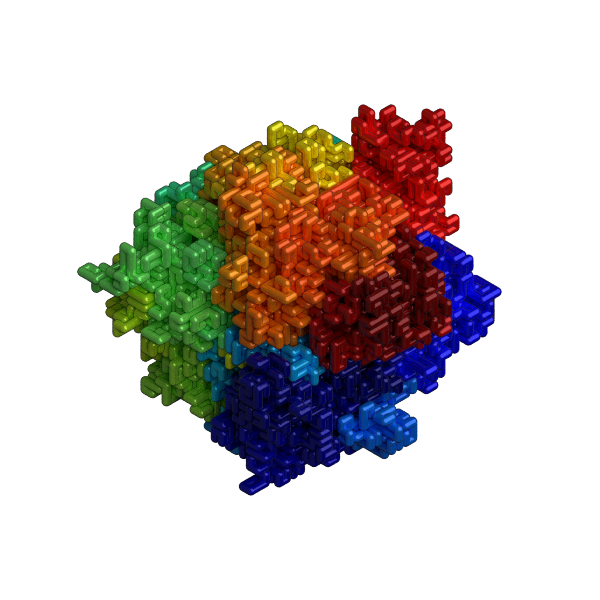

In [9]:
# Visualize starting conformation using the Fresnel backend
render.fresnel(snapshot, cmap="jet").static(pathtrace=True)

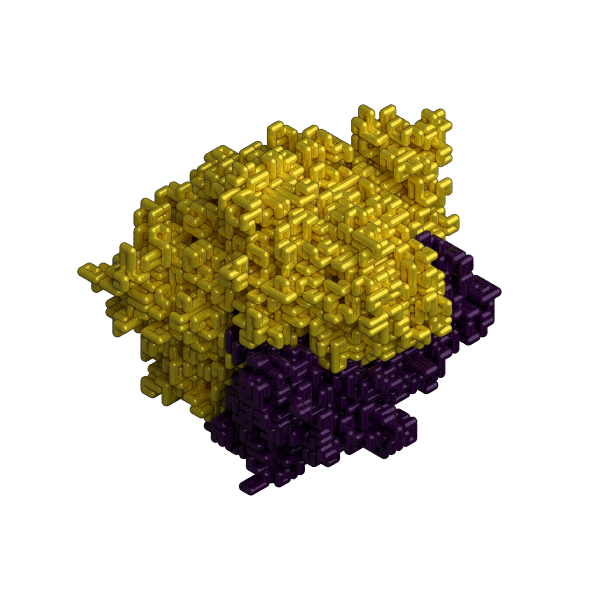

In [10]:
# Render individual chromosomes
render.fresnel(snapshot, show_chromosomes=True).static(pathtrace=True)

In [11]:
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

In [12]:
# Setup neighbor list
nl = hoomd.md.nlist.Cell(buffer=0.4)

In [13]:
# Read input force parameters
with open("force_dict_heteropolymer.json", 'r') as dict_file:
    force_dict = json.load(dict_file)

print(json.dumps(force_dict, indent=4, sort_keys=True))

{
    "Angular forces": {
        "Curvature": {
            "Stiffness": 1.5,
            "Type": "Harmonic"
        }
    },
    "Bonded forces": {
        "Backbone": {
            "Rest length": 1.0,
            "Type": "Harmonic",
            "Wiggle distance": 0.1
        }
    },
    "External forces": {
        "Confinement": {}
    },
    "Non-bonded forces": {
        "Repulsion": {
            "Cutoff": 1.0,
            "Matrix": {
                "A": {
                    "A": 5.0,
                    "B": 5.0
                },
                "B": {
                    "A": 5.0,
                    "B": 5.0
                }
            },
            "Type": "Polychrom"
        }
    }
}


In [14]:
# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)

In [15]:
# Set bonded/angular potentials
bonded_forces = forces.get_bonded_forces(**force_dict)
angular_forces = forces.get_angular_forces(**force_dict)

In [16]:
# Define full force_field
force_field = repulsion_forces + bonded_forces + angular_forces

In [17]:
# HooMD to openMM time conversion factor
t_conv = (1.67377*10**-27/(1.380649*10**-23*300))**0.5

In [18]:
# Initialize integrators and Langevin thermostat
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
integrator = hoomd.md.Integrator(dt=70*t_conv, methods=[langevin], forces=force_field)

In [19]:
# Setup log and simulation engines
logger = log.get_logger(system)

system.operations.integrator = integrator
system.operations.writers.append(log.table_formatter(logger, period=1e4))

In [20]:
# Run
system.run(2e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       10000           5146.45443     0:00:36.918621           1.01470          
       20000           5793.39769     0:00:31.069850           1.01934          
       30000           6045.61244     0:00:28.119566           1.02279          
       40000           6175.33829     0:00:25.909512           1.01681          
       50000           6262.13469     0:00:23.953493           1.01360          
       60000           6320.33598     0:00:22.150721           1.03269          
       70000           6362.22500     0:00:20.433103           1.01617          
       80000           6388.86420     0:00:18.782681           1.00920          
       90000           6414.69786     0:00:17.148119           1.01352          
      100000           6435.32514     0:00:15.539230           1.00160          
      110000           6453.19158     0:00:13.946587           1.00437          
      120000           6464.

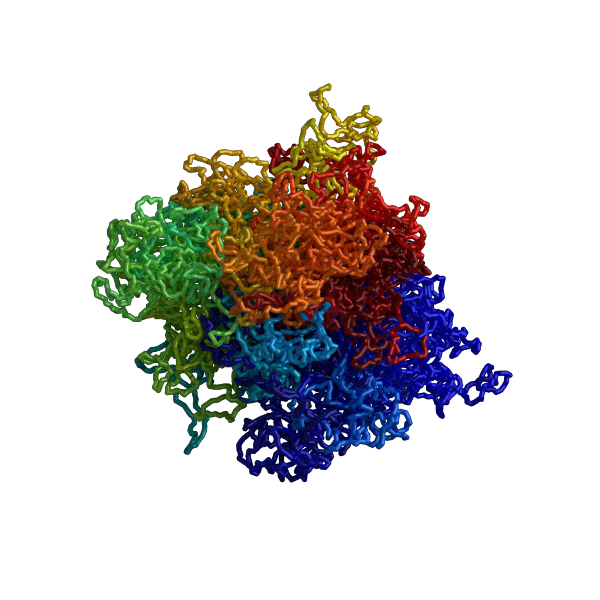

In [21]:
# Visualize new conformation
snapshot_relaxed = system.state.get_snapshot()
render.fresnel(snapshot_relaxed, cmap="jet").static(pathtrace=True)

In [22]:
# Setup domains by assigning monomers to a type 0 (A) or 1 (B)
domain_size = 500

motif = np.zeros(3*domain_size)
motif[domain_size:2*domain_size] = 1

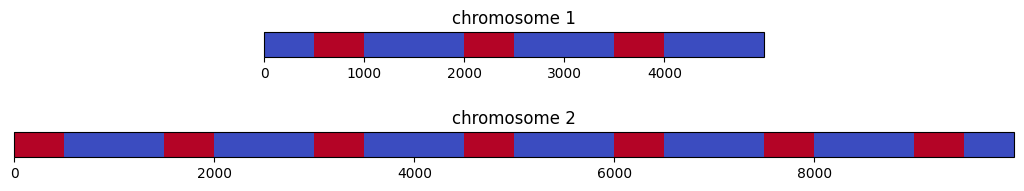

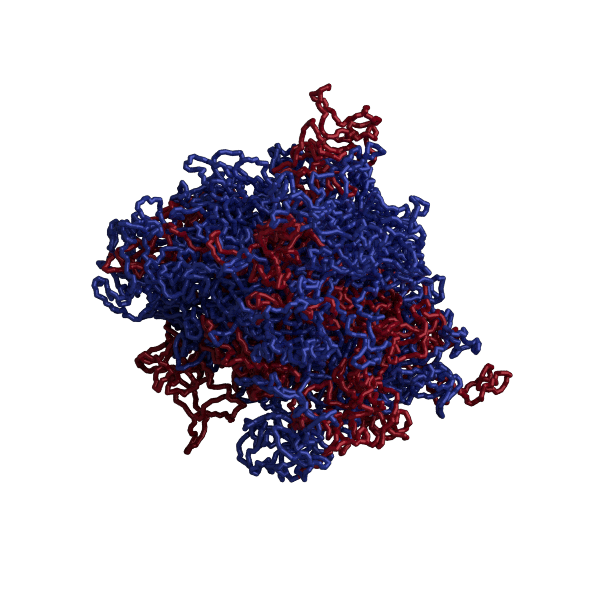

In [23]:
# Assign and visualize domains in 1D/3D
snapshot_relaxed.particles.typeid[:] = np.tile(motif, number_of_monomers//motif.shape[0])

render.domain_viewer(snapshot_relaxed, cmap="coolwarm")
render.fresnel(snapshot_relaxed, show_compartments=True, cmap="coolwarm").static(pathtrace=True)

In [24]:
# Load updated snapshot
system.state.set_snapshot(snapshot_relaxed)

In [25]:
# Set a pseudo square well attraction force acting on B-type monomers
force_dict["Non-bonded forces"]["Attraction"] = {
    "Cutoff": 1.5,
    "Matrix": {
        "A": {
            "A": 0,
            "B": 0
        },
        "B": {
            "A": 0,
            "B": 0.2
        }
    },
    "Type": "Polychrom"
}

In [26]:
# Update force field, including a DPD thermostat
dpd_forces = forces.get_dpd_forces(nl, **force_dict)
attraction_forces = forces.get_attraction_forces(nl, **force_dict)

force_field += attraction_forces + dpd_forces

Setting up DPD with the conservative force contribution disabled


In [27]:
# Setup new DPD integrator
system.operations.remove(integrator)
system.operations.remove(system.operations.writers[0])

nve = hoomd.md.methods.NVE(filter=hoomd.filter.All())
dpd_integrator = hoomd.md.Integrator(dt=5e-3, methods=[nve], forces=force_field)

/home1/tortora/.conda/envs/multistate/lib/python3.10/site-packages/hoomd/md/methods/methods.py:699: FutureWarning: NVE is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantVolume method without a thermostat.
  warnings.warn(


In [28]:
# Update simulation engine
system.operations.integrator = dpd_integrator
system.operations.writers.append(log.table_formatter(logger, period=1e4))

In [29]:
# Run
system.run(2e5)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
      210000           6320.04495     0:00:30.063077           1.06651          
      220000           7037.47573     0:00:25.577353           1.04938          
      230000           7291.33449     0:00:23.315348           1.02427          
      240000           7391.58765     0:00:21.646229           1.03522          
      250000           7450.11897     0:00:20.133907           1.03575          
      260000           7494.34043     0:00:18.680763           1.04532          
      270000           7511.18082     0:00:17.307532           1.04204          
      280000           7527.20932     0:00:15.942163           1.03348          
      290000           7541.74823     0:00:14.585478           1.04139          
      300000           7551.85971     0:00:13.241771           1.02816          
      310000           7560.55354     0:00:11.903890           1.03195          
      320000           7567.

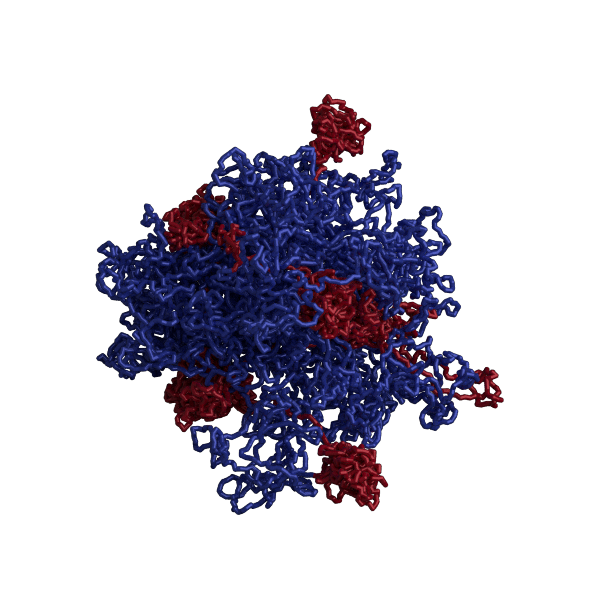

In [30]:
# Visualize new conformation
snapshot_collapsed = system.state.get_snapshot()
render.fresnel(snapshot_collapsed, show_compartments=True, cmap="coolwarm").static(pathtrace=True)